[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Extract wire shape from manual tracing


In [1]:
! pip install svgpathtools
! pip install bezier
! pip install shapely

     |████████████████████████████████| 66 kB 5.6 MB/s 
     |████████████████████████████████| 66 kB 7.0 MB/s 
     |████████████████████████████████| 1.4 MB 32.7 MB/s 
     |████████████████████████████████| 15.7 MB 72.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import numpy as np
import bezier
import shapely
import svgpathtools

## read paths in svg file

the paths are hand traced in Adobe Illustrator

In [2]:
svgfilepath = 'wire.svg'
paths, attributes = svgpathtools.svg2paths(svgfilepath)
paths

[Path(CubicBezier(start=(209.86+175.88j), control1=(209.76000000000002+176.69j), control2=(200.65+253.76999999999998j), end=(242.83+316.66999999999996j)),
      CubicBezier(start=(242.83+316.66999999999996j), control1=(289.26+385.90999999999997j), control2=(349.26+400.46j), end=(391.45000000000005+400.46j)),
      Line(start=(391.45000000000005+400.46j), end=(391.52000000000004+400.46j)),
      CubicBezier(start=(391.52000000000004+400.46j), control1=(457.32000000000005+400.44j), control2=(493.01000000000005+371.63j), end=(508.43000000000006+354.46j)),
      CubicBezier(start=(508.43000000000006+354.46j), control1=(539.19+320.21j), control2=(553.35+281.14j), end=(551.71+226.78999999999996j)))]

## extract coordinates of each segment of each paths

In [3]:
def getcoordinates(svg):
  """ extract xy coordinates of svgpathtools.path.CubicBezier
      the real and imaginary components are x and y coordinates respectively
      the unit is arbitrary
      returns None for input with other data type

  Returns
  -------
  list of 4 tuples
      xy coordinates that defines a cubic bezier curve
  """
  
  if isinstance(svg,svgpathtools.path.CubicBezier):
        return [(svg.start.real,-svg.start.imag),# svg origin is at top left corner
                (svg.control1.real,-svg.control1.imag),
                (svg.control2.real,-svg.control2.imag),
                (svg.end.real,-svg.end.imag)]

nodes = getcoordinates(paths[0][0])
nodes

[(209.86, -175.88),
 (209.76000000000002, -176.69),
 (200.65, -253.76999999999998),
 (242.83, -316.66999999999996)]

## interpolate coordinates of points along Bezier curves at evenly spaced intervals

In [4]:
#columns represent each node while the rows are the dimension of the ambient space
def evaluate_multi(bcurve,seglength=5):
    L = bcurve.length
    N = max(20,int(L/seglength))
    s_vals = np.linspace(0, 1.0, N)
    xy = bcurve.evaluate_multi(s_vals)
    return xy.T.tolist()

c = bezier.Curve.from_nodes(np.asfortranarray(np.array(nodes).T))
evaluate_multi(c)

[[209.86, -175.88],
 [209.81755557580178, -176.25451485058312],
 [209.72263848396506, -177.18800655976676],
 [209.59173013848402, -178.65575300655976],
 [209.44131195335282, -180.63303206997088],
 [209.28786534256557, -183.09512162900873],
 [209.1478717201166, -186.01729956268218],
 [209.03781250000003, -189.37484375],
 [208.97416909620995, -193.14303206997084],
 [208.97342292274053, -197.2971424016035],
 [209.052055393586, -201.8124526239067],
 [209.22654792274056, -206.6642406158892],
 [209.51338192419823, -211.8277842565597],
 [209.9290388119534, -217.2783614249271],
 [210.49, -222.99124999999998],
 [211.21274690233236, -228.94172786078715],
 [212.11376093294461, -235.10507288629736],
 [213.2095235058309, -241.45656295553934],
 [214.51651603498541, -247.9714759475218],
 [216.05121993440235, -254.6250897412536],
 [217.83011661807583, -261.3926822157434],
 [219.8696875, -268.24953124999996],
 [222.1864139941691, -275.170914723032],
 [224.79677751457723, -282.1321105138483],
 [227.7172

## connect segments of Bezier curves together to create a continuous line

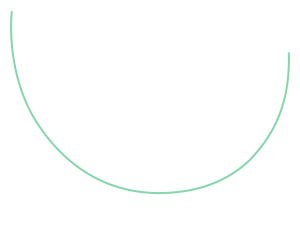

In [5]:
from shapely.geometry import LineString

def connectBeziers(lst):
    xy = []
    for seg in lst:
      nodes = getcoordinates(seg)
      if nodes is None:
        continue
      c = bezier.Curve.from_nodes(np.asfortranarray(np.array(nodes).T))
      xy += evaluate_multi(c)
    return xy

xy = connectBeziers(paths[0])
line = LineString(xy)
line


## convert coordinate unit to millimeter

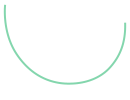

In [8]:
def points_to_mm(geom,width_mm):
    centroid = np.squeeze(geom.centroid.coords)
    geom = shapely.affinity.translate(geom,*(centroid*np.array([-1,-1])))
    minx, miny, maxx, maxy = geom.bounds
    scale = width_mm/(maxx-minx)
    return shapely.affinity.scale(geom, xfact=scale, yfact=scale)

wire_svg_width = 120.9547#tip-tip horizontal distance(in mm)
line = points_to_mm(line,wire_svg_width)
line

## export coordinates to csv table

In [9]:
import pandas as pd
df = pd.DataFrame(line.coords, columns=['x','y'])
df.to_csv('wire.csv')
